# ADS 509 Assignment 2.1: Tokenization, Normalization, Descriptive Statistics 

This notebook holds Assignment 2.1 for Module 2 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In the previous assignment you pulled lyrics data on two artists. In this assignment we explore this data set and a pull from the now-defunct Twitter API for the artists Cher and Robyn.  If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Canvas. 

This assignment asks you to write a short function to calculate some descriptive statistics on a piece of text. Then you are asked to find some interesting and unique statistics on your corpora. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [43]:
# Install necessary package
# pip install emoji

In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation

sw = stopwords.words("english")

In [2]:
# Add any additional import statements you need here

import string
import matplotlib.pyplot as plt


In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "/Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

In [16]:
def descriptive_stats(tokens, num_tokens=5, verbose=True, min_frequency=10):
    """
    Given a list of tokens, print number of tokens, number of unique tokens, 
    number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
    and num_tokens most common tokens with a frequency greater than min_frequency. 
    Return a list with the number of tokens, number of unique tokens, lexical diversity, 
    and number of characters. 
    """
    
    # Calculate the number of tokens
    num_tokens = len(tokens)
    
    # Calculate the number of unique tokens
    num_unique_tokens = len(set(tokens))
    
    # Calculate the number of characters
    num_characters = sum(len(token) for token in tokens)
    
    # Calculate lexical diversity
    lexical_diversity = num_unique_tokens / num_tokens if num_tokens > 0 else 0
    
    # Find the most common tokens, filtering out non-alphabetic tokens and those with frequency <= min_frequency
    token_counts = Counter(token for token in tokens if token.isalpha())
    most_common_tokens = [(token, count) for token, count in token_counts.items() if count > min_frequency]
    
    # Sort the tokens by frequency in descending order
    most_common_tokens.sort(key=lambda x: x[1], reverse=True)
    
    if verbose:
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
        
        # Print the most common tokens with frequency > min_frequency
        print(f"The tokens with a frequency greater than {min_frequency} are:")
        for token, count in most_common_tokens:
            print(f"Token: '{token}' - Count: {count}")
    
    return [num_tokens, num_unique_tokens, lexical_diversity, num_characters]

In [5]:
text = """here is some example text with other example text here in this text""".split()
assert(descriptive_stats(text, verbose=True)[0] == 13)
assert(descriptive_stats(text, verbose=False)[1] == 9)
assert(abs(descriptive_stats(text, verbose=False)[2] - 0.69) < 0.02)
assert(descriptive_stats(text, verbose=False)[3] == 55)


There are 13 tokens in the data.
There are 9 unique tokens in the data.
There are 55 characters in the data.
The lexical diversity is 0.692 in the data.
The 13 most common tokens are:
Token: 'text' - Count: 3
Token: 'here' - Count: 2
Token: 'example' - Count: 2
Token: 'is' - Count: 1
Token: 'some' - Count: 1
Token: 'with' - Count: 1
Token: 'other' - Count: 1
Token: 'in' - Count: 1
Token: 'this' - Count: 1


Q: Why is it beneficial to use assertion statements in your code? 

A: There are several benefits including output ensurance, debugging, error localization, and improved code quality. When we start working with larger datasets, assertion statements can guide our efforts to ensure the code is functioning as intended. This can make sure that we can see the format on a smaller scale while identifying issues with the code. In our example, we were able to identify the word frequency, total tokens, unique tokens, and characters.

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [6]:
# Read in the lyrics data

# Data path
data_location = "/Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/"
lyrics_folder = os.path.join(data_location, "lyrics/")
artists = ["cher", "robyn"]

# Initialize the dictionary to store lyrics
lyrics_data = {}

# Read in the lyrics data
for artist in artists:
    artist_path = os.path.join(lyrics_folder, artist)
    lyrics_data[artist] = {}
    for song_file in os.listdir(artist_path):
        song_path = os.path.join(artist_path, song_file)
        with open(song_path, 'r', encoding='utf-8') as file:
            lyrics_data[artist][song_file] = file.read()

In [7]:
# Read in the twitter data

# Data path
data_location = "/Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/twitter/"

# Initialize the dictionary to store Twitter descriptions
twitter_data = {}

# Read in the twitter data
for twitter_file in os.listdir(data_location):
    if twitter_file.endswith("_followers.txt"):
        continue  # Skip files ending with "_followers.txt"
    
    if twitter_file.startswith(".DS"):  # Skip system files
        continue
    
    artist = twitter_file.split('_')[0]  # Extract artist name
    if artist not in twitter_data:
        twitter_data[artist] = []
    
    file_path = os.path.join(data_location, twitter_file)
    if os.path.getsize(file_path) == 0:
        print(f"Skipping empty file: {twitter_file}")
        continue
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            descriptions = file.readlines()
    except UnicodeDecodeError:
        with open(file_path, 'r', encoding='latin-1') as file:
            descriptions = file.readlines()
    
    twitter_data[artist].extend([desc.strip() for desc in descriptions])


## Data Cleaning

Now clean and tokenize your data. Remove punctuation chacters (available in the `punctuation` object in the `string` library), split on whitespace, fold to lowercase, and remove stopwords. Store your cleaned data, which must be accessible as an interable for `descriptive_stats`, in new objects or in new columns in your data frame. 



In [8]:
# Set up punctuation & stopwords
punctuation = set(string.punctuation)
stop_words = set(stopwords.words('english'))

# Define a function to clean and tokenize text
def clean_and_tokenize(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove non-alphanumeric characters except whitespace
    text = re.sub(r'[^\w\s]', '', text)
    # Fold to lowercase
    text = text.lower()
    # Split on whitespace
    tokens = text.split()
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens


In [9]:
# Define the folder location
twitter_folder = "/Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/twitter/"

# Initialize a dictionary to store the combined data
twitter_data = {
    "robynkonichiwa": [],
    "cher": []
}

# Read and combine all .txt files in the twitter folder
for twitter_file in os.listdir(twitter_folder):
    if twitter_file.endswith('.txt'):
        file_path = os.path.join(twitter_folder, twitter_file)
        if 'robynkonichiwa' in twitter_file:
            artist = "robynkonichiwa"
        elif 'cher' in twitter_file:
            artist = "cher"
        else:
            continue  # Skip files that do not match the expected pattern
        
        with open(file_path, 'r', encoding='latin-1') as file:
            descriptions = file.readlines()
            descriptions = [desc.strip() for desc in descriptions if desc.strip()]  # Remove empty lines
            twitter_data[artist].extend(descriptions)

# Check combined data for each artist
for artist, descriptions in twitter_data.items():
    print(f"{artist}: {len(descriptions)} descriptions")


robynkonichiwa: 716835 descriptions
cher: 7990040 descriptions


In [10]:
# create your clean twitter data here

# Initialize the dictionary to store cleaned Twitter data
cleaned_twitter_data = {}

# Clean and tokenize the Twitter descriptions
for artist, descriptions in twitter_data.items():
    cleaned_descriptions = []
    for description in descriptions:
        cleaned_tokens = clean_and_tokenize(description)
        cleaned_descriptions.extend(cleaned_tokens)
    cleaned_twitter_data[artist] = cleaned_descriptions

In [11]:
# create your clean lyrics data here

# Initialize the dictionary to store cleaned lyrics data
cleaned_lyrics_data = {}

# Clean and tokenize the lyrics
for artist, songs in lyrics_data.items():
    cleaned_lyrics_data[artist] = {}
    for song, lyrics in songs.items():
        cleaned_tokens = clean_and_tokenize(lyrics)
        cleaned_lyrics_data[artist][song] = cleaned_tokens


## Basic Descriptive Statistics

Call your `descriptive_stats` function on both your lyrics data and your twitter data and for both artists (four total calls). 

In [17]:
# calls to descriptive_stats here

# Descriptive_stats function w/ cleaned Twitter data
for artist, tokens in cleaned_twitter_data.items():
    print(f"Descriptive stats for {artist}'s Twitter data:")
    descriptive_stats(tokens, min_frequency=50)
    print("\n")

Descriptive stats for robynkonichiwa's Twitter data:
There are 4245671 tokens in the data.
There are 1108380 unique tokens in the data.
There are 27534895 characters in the data.
The lexical diversity is 0.261 in the data.
The tokens with a frequency greater than 50 are:
Token: 'ð' - Count: 16747
Token: 'â' - Count: 16425
Token: 'music' - Count: 16050
Token: 'sweden' - Count: 12721
Token: 'love' - Count: 12191
Token: 'new' - Count: 10249
Token: 'stockholm' - Count: 9701
Token: 'im' - Count: 9287
Token: 'de' - Count: 8510
Token: 'london' - Count: 8350
Token: 'och' - Count: 8005
Token: 'life' - Count: 7584
Token: 'england' - Count: 6474
Token: 'follow' - Count: 5820
Token: 'ca' - Count: 5693
Token: 'sverige' - Count: 5543
Token: 'york' - Count: 5190
Token: 'los' - Count: 5099
Token: 'en' - Count: 5070
Token: 'like' - Count: 5052
Token: 'lover' - Count: 4864
Token: 'pã' - Count: 4842
Token: 'la' - Count: 4796
Token: 'ny' - Count: 4522
Token: 'angeles' - Count: 4354
Token: 'usa' - Count: 4

In [19]:
# Descriptive_stats function w/ cleaned lyrics data
for artist, songs in cleaned_lyrics_data.items():
    for song, tokens in songs.items():
        print(f"Descriptive stats for {artist}'s song '{song}':")
        descriptive_stats(tokens, min_frequency=3)
        print("\n")

Descriptive stats for cher's song 'cher_comeandstaywithme.txt':
There are 78 tokens in the data.
There are 47 unique tokens in the data.
There are 342 characters in the data.
The lexical diversity is 0.603 in the data.
The tokens with a frequency greater than 3 are:
Token: 'ill' - Count: 8
Token: 'stay' - Count: 7
Token: 'come' - Count: 5
Token: 'youll' - Count: 5
Token: 'true' - Count: 4


Descriptive stats for cher's song 'cher_pirate.txt':
There are 144 tokens in the data.
There are 78 unique tokens in the data.
There are 637 characters in the data.
The lexical diversity is 0.542 in the data.
The tokens with a frequency greater than 3 are:
Token: 'love' - Count: 11
Token: 'pirate' - Count: 8
Token: 'know' - Count: 8
Token: 'much' - Count: 5
Token: 'sea' - Count: 5


Descriptive stats for cher's song 'cher_stars.txt':
There are 160 tokens in the data.
There are 106 unique tokens in the data.
There are 774 characters in the data.
The lexical diversity is 0.662 in the data.
The tokens 

Q: How do you think the "top 5 words" would be different if we left stopwords in the data? 

A: Keeping stop words in the data will add noise and complicate attaining meaningful insight. Stopwords would more likely be the most frequently recurring words offering little value. In this instance, the removal of stopwords allow us to focus on words that can best pertain towards extracting meaningful insight. 

---

Q: What were your prior beliefs about the lexical diversity between the artists? Does the difference (or lack thereof) in lexical diversity between the artists conform to your prior beliefs? 

A: Prior to this assignment, I had very limited understanding on what lexical diversity meant and its importance. While I am familiar with Cher, I had not heard of the singer Robyn. After listing a few of her songs, I was not too surprised that her lexical value was lower than Cher as her songs are repeatitive in nature. The lack of unique words negatively impact lexical diversity. In this instance, the focus of developing a catchy song that is repetitive in nature can be the focus while other artist may long towards creating a story for listeners to follow. 



## Specialty Statistics

The descriptive statistics we have calculated are quite generic. You will now calculate a handful of statistics tailored to these data.

1. Ten most common emojis by artist in the twitter descriptions.
1. Ten most common hashtags by artist in the twitter descriptions.
1. Five most common words in song titles by artist. 
1. For each artist, a histogram of song lengths (in terms of number of tokens) 

We can use the `emoji` library to help us identify emojis and you have been given a function to help you.


In [21]:
assert(emoji.is_emoji("❤️"))
assert(not emoji.is_emoji(":-)"))

### Emojis 😁

What are the ten most common emojis by artist in the twitter descriptions? 


In [34]:
def extract_emojis(text):
    emoji_regex = r'[\U0001F300-\U0001F5FF\u2600-\u26FF\u2700-\u27BF]'
    return ''.join(re.findall(emoji_regex, text))

# Define file paths
robynkonichiwa_file_path = "/Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/twitter/robynkonichiwa_followers_data.txt"
cher_file_path = "/Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/twitter/cher_followers_data.txt"

# Function to extract emojis from file
def extract_emojis_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = file.read()
        return extract_emojis(data)

# Extract emojis for robynkonichiwa
robynkonichiwa_emojis = extract_emojis_from_file(robynkonichiwa_file_path)

# Extract emojis for cher
cher_emojis = extract_emojis_from_file(cher_file_path)

# Count emojis for robynkonichiwa
robynkonichiwa_emoji_counts = Counter(robynkonichiwa_emojis)

# Count emojis for cher
cher_emoji_counts = Counter(cher_emojis)

# Find top ten emojis for robynkonichiwa
top_ten_robynkonichiwa_emojis = robynkonichiwa_emoji_counts.most_common(10)

# Find top ten emojis for cher
top_ten_cher_emojis = cher_emoji_counts.most_common(10)

# Print top ten emojis for robynkonichiwa
print("Top ten emojis for Robynkonichiwa:")
for emoji, count in top_ten_robynkonichiwa_emojis:
    print(f"{emoji}: {count}")

# Print top ten emojis for cher
print("\nTop ten emojis for Cher:")
for emoji, count in top_ten_cher_emojis:
    print(f"{emoji}: {count}")

Top ten emojis for Robynkonichiwa:
🌈: 6086
❤: 5635
🏳: 4641
♥: 4249
✨: 3217
♡: 1901
🏻: 1751
✌: 1495
♀: 1347
🏼: 1340

Top ten emojis for Cher:
❤: 94506
🌈: 66291
♥: 48059
🏳: 47174
✨: 45846
♡: 32042
🌊: 31234
💙: 31050
🏻: 25195
✌: 21963


### Hashtags

What are the ten most common hashtags by artist in the twitter descriptions? 


In [35]:
# Your code here

# Function to extract hashtags from text
def extract_hashtags(text):
    return re.findall(r'#\w+', text)

# Function to read data from file and extract hashtags for each artist
def get_top_ten_hashtags_by_artist(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = file.read().splitlines()
        
    hashtags = []
    for line in data:
        hashtags.extend(extract_hashtags(line))
    
    # Count hashtags
    hashtag_counts = Counter(hashtags)
    
    # Find top ten hashtags
    top_ten_hashtags = hashtag_counts.most_common(10)
    
    return top_ten_hashtags

# File paths for artists
robynkonichiwa_file_path = "/Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/twitter/robynkonichiwa_followers_data.txt"
cher_file_path = "/Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/twitter/cher_followers_data.txt"

# Get top ten hashtags for Robynkonichiwa
top_ten_hashtags_robynkonichiwa = get_top_ten_hashtags_by_artist(robynkonichiwa_file_path)

# Get top ten hashtags for Cher
top_ten_hashtags_cher = get_top_ten_hashtags_by_artist(cher_file_path)

# Print top ten hashtags for Robynkonichiwa
print("Top ten hashtags for Robynkonichiwa:")
for hashtag, count in top_ten_hashtags_robynkonichiwa:
    print(f"{hashtag}: {count}")

# Print top ten hashtags for Cher
print("\nTop ten hashtags for Cher:")
for hashtag, count in top_ten_hashtags_cher:
    print(f"{hashtag}: {count}")

Top ten hashtags for Robynkonichiwa:
#BlackLivesMatter: 356
#BLM: 345
#1: 228
#blacklivesmatter: 222
#music: 175
#Music: 114
#EDM: 87
#LGBTQ: 76
#blm: 60
#TeamFollowBack: 59

Top ten hashtags for Cher:
#BLM: 10100
#Resist: 6161
#BlackLivesMatter: 4888
#resist: 3860
#FBR: 3330
#1: 3111
#TheResistance: 3044
#blacklivesmatter: 2738
#Resistance: 1953
#RESIST: 1878


### Song Titles

What are the five most common words in song titles by artist? The song titles should be on the first line of the lyrics pages, so if you have kept the raw file contents around, you will not need to re-read the data.


In [36]:
# Your code here

# Function to get the first line of lyrics from each song
def get_first_line_lyrics(artist_data):
    first_lines = []
    for song_title, lyrics in artist_data.items():
        # Split lyrics into lines and take the first line
        first_line = lyrics.split('\n')[0]
        first_lines.append(first_line)
    return first_lines

# Function to get the five most common words in song titles
def get_top_five_words(artist_data):
    first_lines = get_first_line_lyrics(artist_data)
    # Join all first lines into a single string
    all_titles = ' '.join(first_lines)
    # Tokenize the string into words
    words = all_titles.split()
    # Count occurrences of each word
    word_counts = Counter(words)
    # Find the five most common words
    top_five_words = word_counts.most_common(5)
    return top_five_words

# Initialize the dictionary to store top five words for each artist
top_five_words_by_artist = {}

# Iterate over each artist's lyrics data
for artist, data in lyrics_data.items():
    # Get the top five words for the artist
    top_five_words_by_artist[artist] = get_top_five_words(data)

# Print the top five words for each artist
for artist, top_five_words in top_five_words_by_artist.items():
    print(f"Top five words in song titles for {artist.capitalize()}:")
    for word, count in top_five_words:
        print(f"{word}: {count}")
    print()

Top five words in song titles for Cher:
The: 29
To: 28
"The: 24
Of: 21
"I: 21

Top five words in song titles for Robyn:
Me: 7
You: 7
The: 7
My: 6
To: 6



### Song Lengths

For each artist, a histogram of song lengths (in terms of number of tokens). If you put the song lengths in a data frame with an artist column, matplotlib will make the plotting quite easy. An example is given to help you out. 


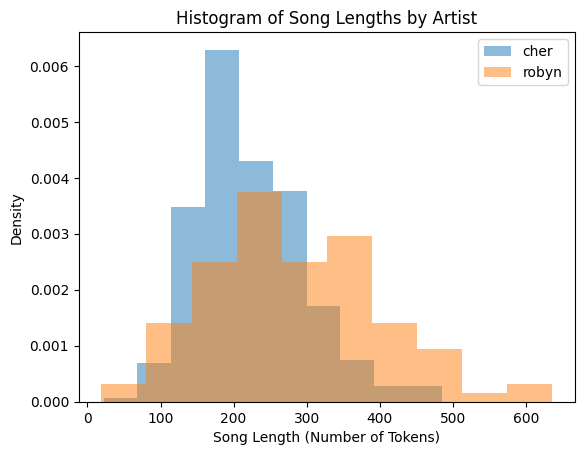

In [37]:
# Function to calculate song lengths for an artist
def calculate_song_lengths(artist_data):
    song_lengths = []
    for song_title, lyrics in artist_data.items():
        # Tokenize the lyrics into words
        tokens = lyrics.split()
        # Count the number of tokens
        length = len(tokens)
        song_lengths.append(length)
    return song_lengths

# Initialize lists to store artist names and song lengths
artists_list = []
lengths_list = []

# Iterate over each artist's lyrics data
for artist, data in lyrics_data.items():
    # Calculate song lengths for the artist
    song_lengths = calculate_song_lengths(data)
    # Append artist names and corresponding song lengths
    artists_list.extend([artist] * len(song_lengths))
    lengths_list.extend(song_lengths)

# Create a DataFrame with artist and song length columns
df = pd.DataFrame({"artist": artists_list, "length": lengths_list})

# Plot histograms of song lengths for each artist
df.groupby('artist')['length'].plot(kind="hist", density=True, alpha=0.5, legend=True)

# Add labels and title
plt.xlabel("Song Length (Number of Tokens)")
plt.ylabel("Density")
plt.title("Histogram of Song Lengths by Artist")

# Show the plot
plt.show()

Since the lyrics may be stored with carriage returns or tabs, it may be useful to have a function that can collapse whitespace, using regular expressions, and be used for splitting. 

Q: What does the regular expression `'\s+'` match on? 

A: This was a concept that I originally struggled to understand, but it appears to focus on the amount of whitespace characters that may include an indentation or new line. Many times, this can be indicative of the start of a new scenario or case. Therefore, understanding the text structure can be equally as informative for NLP.

In [38]:
collapse_whitespace = re.compile(r'\s+')

def tokenize_lyrics(lyric) : 
    """strip and split on whitespace"""
    return([item.lower() for item in collapse_whitespace.split(lyric)])

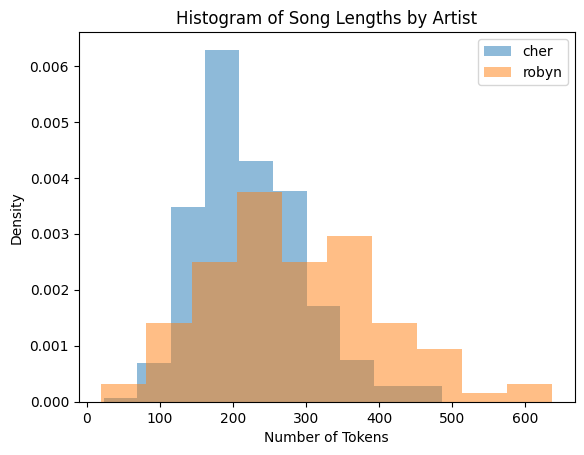

In [42]:
# Your lyric length comparison chart here. 

import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Regular expression for collapsing whitespace
collapse_whitespace = re.compile(r'\s+')

# Function to tokenize lyrics
def tokenize_lyrics(lyric):
    """Strip and split on whitespace"""
    return [item.lower() for item in collapse_whitespace.split(lyric)]

# Data path
data_location = "/Users/jesse/Desktop/School/University of San Diego/ADS 509- Applied Text Mining/Module 2/ads-tm-token-norm/M1 Results/"
lyrics_folder = os.path.join(data_location, "lyrics/")
artists = ["cher", "robyn"]

# Initialize lists to store token lengths
artist_list = []
length_list = []

# Read in the lyrics data and tokenize
for artist in artists:
    artist_path = os.path.join(lyrics_folder, artist)
    for song_file in os.listdir(artist_path):
        song_path = os.path.join(artist_path, song_file)
        with open(song_path, 'r', encoding='utf-8') as file:
            # Tokenize lyrics
            lyrics = file.read()
            tokens = tokenize_lyrics(lyrics)
            # Store artist and token length
            artist_list.append(artist)
            length_list.append(len(tokens))

# Create DataFrame
df = pd.DataFrame({
    "artist": artist_list,
    "length": length_list
})

# Plot histogram
df.groupby('artist')['length'].plot(kind="hist", density=True, alpha=0.5, legend=True)
plt.xlabel('Number of Tokens')
plt.ylabel('Density')
plt.title('Histogram of Song Lengths by Artist')
plt.show()

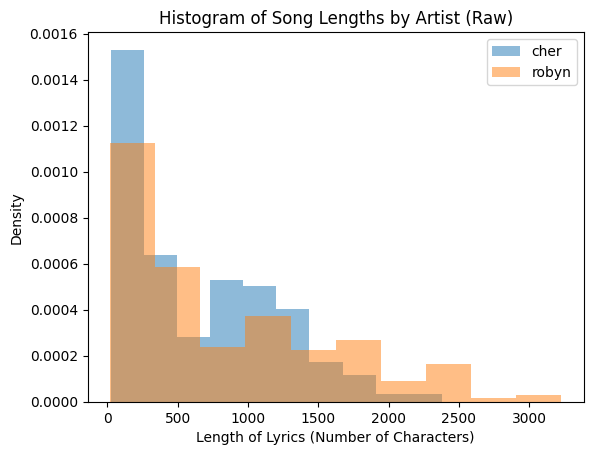

In [43]:
# I wanted to see how the output would vary if I try to process the raw data w/out tokenization

# Read in the lyrics data w/o tokenizing
for artist in artists:
    artist_path = os.path.join(lyrics_folder, artist)
    for song_file in os.listdir(artist_path):
        song_path = os.path.join(artist_path, song_file)
        with open(song_path, 'r', encoding='utf-8') as file:
            # Read lyrics w/o tokenizing
            lyrics = file.read()
            # Store artist and length
            artist_list.append(artist)
            length_list.append(len(lyrics))

# Create DataFrame
df = pd.DataFrame({
    "artist": artist_list,
    "length": length_list
})

# Plot histogram
df.groupby('artist')['length'].plot(kind="hist", density=True, alpha=0.5, legend=True)
plt.xlabel('Length of Lyrics (Number of Characters)')
plt.ylabel('Density')
plt.title('Histogram of Song Lengths by Artist (Raw)')
plt.show()
